**Importing Requisites**

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tensorboard 1.8.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.8.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

``**LOADING DATA**``

Normalize a tensor image with mean and standard deviation.
Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
will normalize each channel of the input ``torch.*Tensor`` i.e.
``input[channel] = (input[channel] - mean[channel]) / std[channel]``

In [3]:
transform  = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.FashionMNIST(root='./fashionMNIST/', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.FashionMNIST(root='./fashionMNIST/', train=False,
                                       download=True, transform=transform)

In [4]:
print('The Length of Train set is : {} and of Test set is {}'.format(len(trainset), len(testset)))

The Length of Train set is : 60000 and of Test set is 10000


**Setting contraints like ``batch size``, ``epochs``, ``learning rate``**

In [5]:
batch_size = 100
n_iters = 5500
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)

learning_rate = 0.001

<b>class torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)</b>
    
**Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.**

Parameters:	
- dataset (Dataset) – dataset from which to load the data.
- batch_size (int, optional) – how many samples per batch to load (default: 1).
- shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
- sampler (Sampler, optional) – defines the strategy to draw samples from the dataset. If specified, shuffle must be False.
- batch_sampler (Sampler, optional) – like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.
- num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
- collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
- pin_memory (bool, optional) – If True, the data loader will copy tensors into CUDA pinned memory before returning them.
- drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
- timeout (numeric, optional) – if positive, the timeout value for collecting a batch from workers. Should always be non-negative. (default: 0)
- worker_init_fn (callable, optional) – If not None, this will be called on each worker subprocess with the worker id (an int in [0, num_workers - 1]) as input, after seeding and before data loading. (default: None)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                           batch_size=batch_size,            
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

**Making Dictionary assigining label name to labels**

In [7]:
classes = {0 : 'T-Shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
           4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag',
           9 : 'Ankle boot'}

** Lets Plot some of the data **

In [8]:
def imshow(image, label):
    plt.title(classes[label])
    plt.imshow(image.reshape(28, 28), cmap = 'Greys', interpolation = 'nearest')

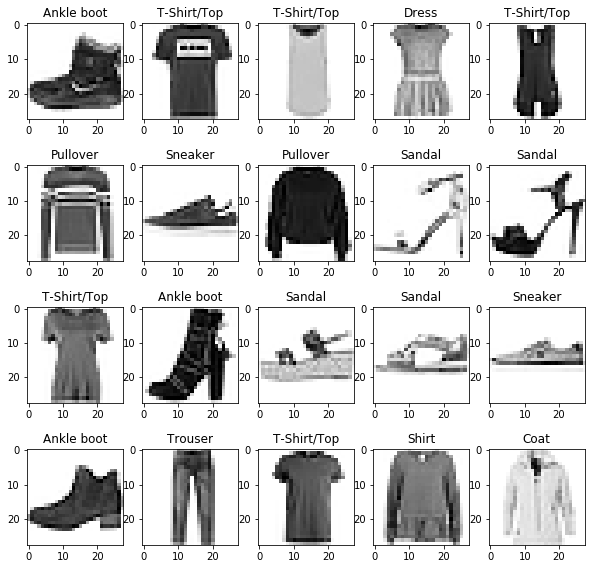

In [9]:
fig = plt.figure(figsize=(10,10))
column = 5
row = 4

for num in range(0, 20):
    image, label = trainset.train_data[num], trainset.train_labels[num].item()
    num += 1
    fig.add_subplot(row, column, num)
    imshow(image, label)

**Defining ``Convnet``**

We have three layer network with Two convolutional layer and One fully connected layer.
The architecture for this follows as:
1. Convolutional Layer
Filter 5x5 with stride of 1 and padding of 2.
2. Batch Normalization Layer
Batch Normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.
3. ReLU Layer
4. Pool Layer
Max pool of filter 2x2 and stride of 2

Conv layer -->> Batch Norm Layer -->> ReLU non linearity -->> Max Pool layer -->> Conv layer -->> Batch Norm layer -->> ReLU Nonlinearity -->> Max Pool layer -->> Fully Connected layer

In [10]:
class convnet1(nn.Module):
    def __init__(self):
        super(convnet1, self).__init__()
        
        # Constraints for layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride = 1, padding=2)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) #default stride is equivalent to the kernel_size
        
        # Constraints for layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding=2)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Defining the Linear layer
        self.fc = nn.Linear(32*7*7, 10)
    
    # defining the network flow
    def forward(self, x):
        # Conv 1
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu1(out)
        
        # Max Pool 1
        out = self.pool1(out)
        
        # Conv 2
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.relu2(out)
        
        # Max Pool 2
        out = self.pool2(out)
        
        out = out.view(out.size(0), -1)
        # Linear Layer
        out = self.fc(out)
        
        return out

In [11]:
model = convnet1()

In [12]:
model.parameters

<bound method Module.parameters of convnet1(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)>

**Defining ``Loss Function`` and ``Optimizer``**

In [13]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Start training model**

In [14]:
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader, 0):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimizer
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0])
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1,\
                     len(trainset)//batch_size, loss.data[0]))

Epoch : 1/9, Iter : 100/600,  Loss: 0.5050
Epoch : 1/9, Iter : 200/600,  Loss: 0.3706
Epoch : 1/9, Iter : 300/600,  Loss: 0.4785
Epoch : 1/9, Iter : 400/600,  Loss: 0.4838
Epoch : 1/9, Iter : 500/600,  Loss: 0.2988
Epoch : 1/9, Iter : 600/600,  Loss: 0.2836
Epoch : 2/9, Iter : 100/600,  Loss: 0.2311
Epoch : 2/9, Iter : 200/600,  Loss: 0.3951
Epoch : 2/9, Iter : 300/600,  Loss: 0.3239
Epoch : 2/9, Iter : 400/600,  Loss: 0.2617
Epoch : 2/9, Iter : 500/600,  Loss: 0.3622
Epoch : 2/9, Iter : 600/600,  Loss: 0.3495
Epoch : 3/9, Iter : 100/600,  Loss: 0.1733
Epoch : 3/9, Iter : 200/600,  Loss: 0.3492
Epoch : 3/9, Iter : 300/600,  Loss: 0.4085
Epoch : 3/9, Iter : 400/600,  Loss: 0.1587
Epoch : 3/9, Iter : 500/600,  Loss: 0.3578
Epoch : 3/9, Iter : 600/600,  Loss: 0.3161
Epoch : 4/9, Iter : 100/600,  Loss: 0.2318
Epoch : 4/9, Iter : 200/600,  Loss: 0.2255
Epoch : 4/9, Iter : 300/600,  Loss: 0.2611
Epoch : 4/9, Iter : 400/600,  Loss: 0.2684
Epoch : 4/9, Iter : 500/600,  Loss: 0.4423
Epoch : 4/9

**Saving the model**

This will save only model parameters

In [16]:
torch.save(model.state_dict(), './model/convnet1.pt')

**For loading the model**

In [17]:
conv1 = convnet1()
conv1.load_state_dict(torch.load('./model/convnet1.pt'))

**`Evaluating` the model**

In [18]:

correct = 0
total = 0

for images, labels in test_loader:
  images = Variable(images.float())
  
  output = conv1(images)
  _, predicted = torch.max(output.data, 1)
  
  total += labels.size(0)
  correct += (predicted == labels).sum()

  
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.0000 %


** Plotting ``Losses``**

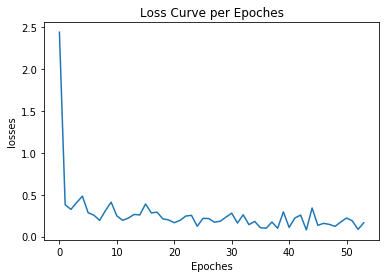

In [22]:
loss = losses[0::100]
plt.xlabel('Epoches')
plt.ylabel('losses')
plt.title('Loss Curve per Epoches')
plt.plot(loss)
plt.show()

**DONE!**